# Exploration
#### Dedicated to purely exploring the data, observing trends, and seeing what quirks the datasets might uncover
For larger trends and analyses on the dataset, visit `results.ipynb`

In [1]:
from data.render import *
from data.load import *
from data.api import *

## Section 1: Cross-Referencing Datasets & Examining Inconsistencies

The first dataset we're observing consists of 5000 entries of albums rated by users on a platform called AOTY (albumoftheyear.org). The highest rated album on this platform is 2015's "To Pimp a Butterfly" by Kendrick Lamar, with a rating of 95/100. *(1)*

In [2]:
show(get_rows(df_aoty, 0).to_frame().T)

rank,title,artist,release_date,genres,user_score,rating_count,album_link
1,To Pimp a Butterfly,Kendrick Lamar,"March 15, 2015","Conscious Hip Hop, Jazz Rap, West Coast Hip Hop",95,"28,594 ratings",https://www.albumoftheyear.org/album/29250-kendrick-lamar-to-pimp-a-butterfly.php


For curiosity's sake, let's examine the frequency of Kendrick Lamar entries within AOTY's top 5000 user-rated albums.

In [3]:
show(filter(df_aoty, 'artist', 'Kendrick Lamar'))
freq = count_occurrences(df_aoty, 'artist', 'Kendrick Lamar') / len(df_aoty) * 100
print(f'{str(freq)}% of albums by Kendrick Lamar exist in the T5000 rankings')


rank,title,artist,release_date,genres,user_score,rating_count,album_link
1,To Pimp a Butterfly,Kendrick Lamar,"March 15, 2015","Conscious Hip Hop, Jazz Rap, West Coast Hip Hop",95,"28,594 ratings",https://www.albumoftheyear.org/album/29250-kendrick-lamar-to-pimp-a-butterfly.php
2,"good kid, m.A.A.d city",Kendrick Lamar,"October 22, 2012","Conscious Hip Hop, West Coast Hip Hop",94,"22,283 ratings",https://www.albumoftheyear.org/album/3840-kendrick-lamar-good-kid-maad-city.php
399,Mr. Morale & The Big Steppers,Kendrick Lamar,"May 13, 2022","Conscious Hip Hop, West Coast Hip Hop",86,"19,284 ratings",https://www.albumoftheyear.org/album/494992-kendrick-lamar-mr-morale-the-big-steppers.php
694,DAMN.,Kendrick Lamar,"April 14, 2017","Conscious Hip Hop, West Coast Hip Hop",84,"20,892 ratings",https://www.albumoftheyear.org/album/76870-kendrick-lamar-damn.php
2092,Section.80,Kendrick Lamar,"July 2, 2011","Conscious Hip Hop, West Coast Hip Hop",81,"10,653 ratings",https://www.albumoftheyear.org/album/2725-kendrick-lamar-section80.php


0.1% of albums by Kendrick Lamar exist in the T5000 rankings


Although 0.1% sounds insignificant, every single one of Kendrick's studio albums makes the list, so by rater metrics on AOTY, he is a certainly a chart topper. It's even more impressive that two of his albums comprise the top 2 entries in the dataset.

This is where we introduce the other dataset, Spotify's Top 200. This dataset is taken directly from Spotify and contains the top 200 most streamed songs, of all time. Unsurprisingly capping out the list is "Blinding Lights" by The Weeknd, a song which dominated the Covid-19 & post-Covid streaming era:

In [4]:
show(get_rows(df_top100s, 0).to_frame().T)

rank,title,artist,top genre,year,beats.per.minute,energy,danceability,loudness.dB,liveness,valance,length,acousticness,speechiness,popularity
1,Blinding Lights,The Weeknd,canadian contemporary r&b,2020,171,73,51,-6,9,33,200,0,6,91


But the reason I introduce the new dataset is I'm more interested in if AOTY's critic rankings match the general consensus of the public. That is, does "To Pimp a Butterfly" and "good kid m.A.A.d city's chart performance match its critic acclaim? Let's observe the frequency of Kendrick Lamar in the top 200:

In [5]:
show(filter(df_top100s, 'artist', 'Kendrick Lamar'))

rank,title,artist,top genre,year,beats.per.minute,energy,danceability,loudness.dB,liveness,valance,length,acousticness,speechiness,popularity
46,HUMBLE.,Kendrick Lamar,conscious hip hop,2017,150,62,91,-7,10,42,177,0,10,81


Observe that Kendrick Lamar's best work (according to critics) doesn't make it anywhere on the Spotify Top 200 chart: instead, we see "HUMBLE" - a 2017 track from "DAMN" which was rated 694th on AOTY. *(1)*

This may suggest two different things. One possibility is that "HUMBLE" significantly outshines Kendrick Lamar's other work, but as a whole, "DAMN" is not that great of an album. Another possiblity is that the general public and the average critic do not agree on what makes good music. We need to dive deeper- we introduce a third and final component, Spotify's Web API: using their API endpoints for album metadata, we can find out if album popularity (according to Spotify metrics) align with critic rankings *(3)*

In [6]:
kendrick_albums = filter(df_aoty, 'artist', 'Kendrick Lamar').copy()
kendrick_albums.loc[:, 'popularity'] = kendrick_albums['title'].apply(lambda title: get_popularity(title))
kendrick_albums_sorted = kendrick_albums.sort_values(by='popularity', ascending=False).reset_index(drop=True)
kendrick_albums_sorted.insert(0, 'relative_rank', range(1, len(kendrick_albums_sorted) + 1))
show(kendrick_albums_sorted[['relative_rank', 'title', 'popularity']])

relative_rank,title,popularity
1,DAMN.,88
2,Mr. Morale & The Big Steppers,83
3,To Pimp a Butterfly,80
4,"good kid, m.A.A.d city",76
5,Section.80,74


To demonstrate the difference, here's a table of the relative rankings for user reviews on AOTY:

In [7]:
albums = get_col(filter(df_aoty, 'artist', 'Kendrick Lamar'), 'title').T.to_frame()
ratings = get_col(filter(df_aoty, 'artist', 'Kendrick Lamar'), 'user_score').T.to_frame()
albums.insert(0, 'rank', range(1, len(albums) + 1))
albums.insert(2, 'user_score', ratings)
show(albums)

rank,title,user_score
1,To Pimp a Butterfly,95
2,"good kid, m.A.A.d city",94
3,Mr. Morale & The Big Steppers,86
4,DAMN.,84
5,Section.80,81


The key discovery here is that critics (on AOTY) and the general public (Spotify users) do not necessarily agree on the ranking of albums. Popularity doesn't match the critic scores: in fact, besides "Section.80", the list almost appears flipped.

---

## Section 2: Song Characteristics in the Charts

The next section I'm exploring is if there's potentially a trend for what specific components makes a song popular. While there's likely to be the a handful of songs that become hits because of some other counfounding reason (memes, controversy, extraordinary promotion and industry push), I want to see if there's potentially some consistent ways to top the charts. For this, we will use Spotify's Top 100 songs dataset.

There are a few metrics of interest for this section. These include beats per minute, energy, danceability, among other things.

In [8]:
show(get_rows(df_top100s, 0).to_frame().T)

rank,title,artist,top genre,year,beats.per.minute,energy,danceability,loudness.dB,liveness,valance,length,acousticness,speechiness,popularity
1,Blinding Lights,The Weeknd,canadian contemporary r&b,2020,171,73,51,-6,9,33,200,0,6,91


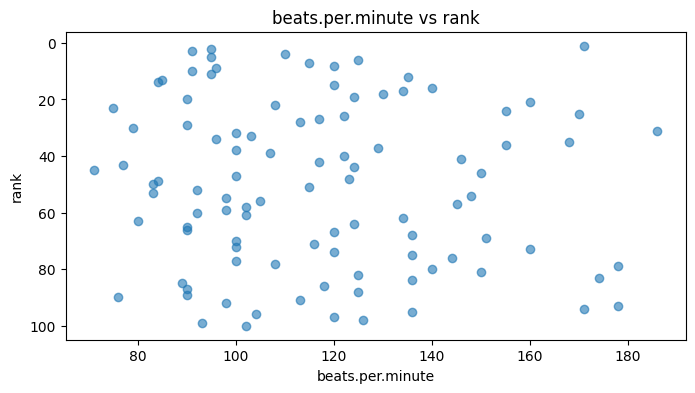

In [9]:
plot(df_top100s, 'beats.per.minute', 'rank', reverse=True)

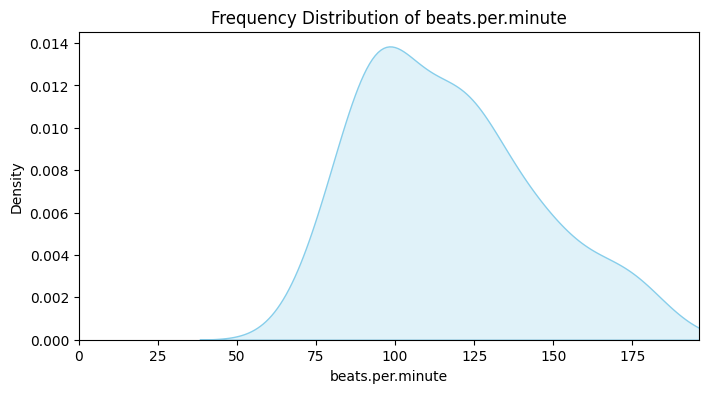

In [10]:
plot_density(df_top100s, 'beats.per.minute', scaled=False)

Overall, there's not much consistency here: there is a lack of entries in the 150+ bpm range, but we can atribute this to a variety of factors: songs in that range aren't as common and songs might be interpreted in half-time (i.e. it could be that 160bpm = 80bpm for some entries). The #1 song (Blinding Lights) sits on the higher end of BPM, but its chart followers sit below 120 bpm. Not much here- we should explore something else:

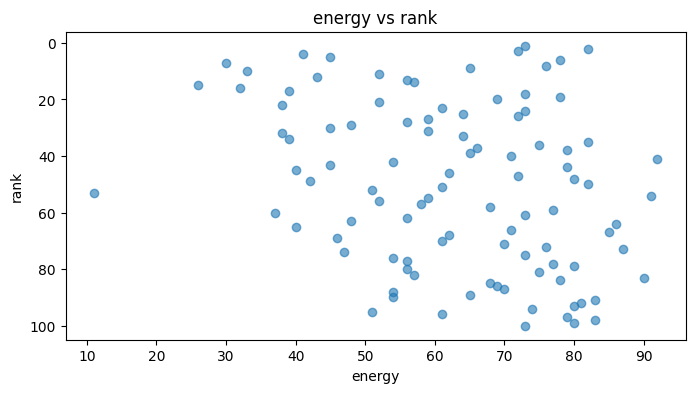

In [11]:
plot(df_top100s, 'energy', 'rank', reverse=True)

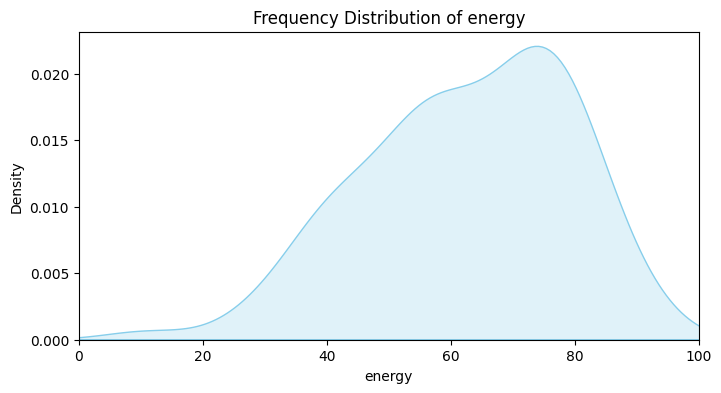

In [12]:
plot_density(df_top100s, 'energy')

Here's a more interesting result. Almost none of the Top 100 songs have an energy below 30. There are only two entries with this characteristic, and one outlier entry has an energy of around 10. Let's crack down on the numbers a bit more. Note that Spotify uses a scale of 100 for their energy metric.

In [13]:
freq = split_proportion(df_top100s, 'energy', 50)
print(f'{str(freq['above_split'])}% of songs in the top 100 have an energy level above 50')
print(f'{str(freq['below_split'])}% of songs in the top 100 have an energy level below or equal to 50')
print(f'Mean energy of entire set: {str(get_col(df_top100s, "energy").mean())}')
print(f'Median energy of entire set: {str(get_col(df_top100s, "energy").median())}')
print(f'Standard deviation of energy of entire set: {str(get_col(df_top100s, "energy").std())}')

78% of songs in the top 100 have an energy level above 50
22% of songs in the top 100 have an energy level below or equal to 50
Mean energy of entire set: 62.68
Median energy of entire set: 64.5
Standard deviation of energy of entire set: 16.491736528861168


In [14]:
print(f'Mean energy of top 50: {str(get_rows(df_top100s, 0, 50)["energy"].mean())}')
print(f'Median energy of top 50: {str(get_rows(df_top100s, 0, 50)["energy"].median())}')
print(f'Mean energy of bottom 50: {str(get_rows(df_top100s, 50, 100)["energy"].mean())}')
print(f'Median energy of bottom 50: {str(get_rows(df_top100s, 50, 100)["energy"].median())}')

Mean energy of top 50: 59.48
Median energy of top 50: 61.5
Mean energy of bottom 50: 65.88
Median energy of bottom 50: 68.5


Therefore, we attain a more concrete result: the most popular songs on Spotify tend to have a higher energy level. There is not much variation and the Top 50 songs on Spotify do not differ much from the following 50 entries. But does this also correspond with danceability? (the two often go hand-in-hand: a song with high danceability typically has higher energy)

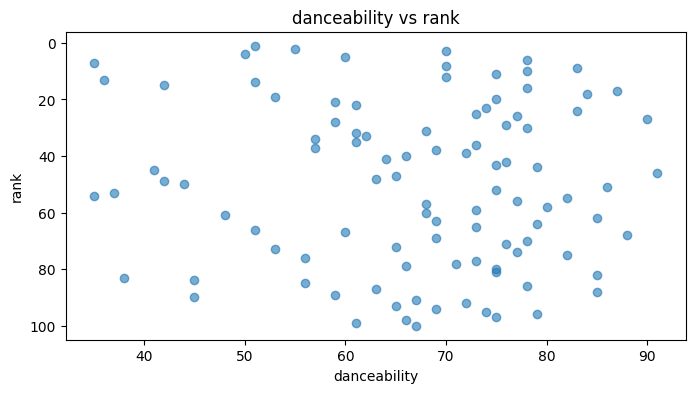

In [15]:
plot(df_top100s, 'danceability', 'rank', reverse=True)

Much like BPM, this scatterplot doesn't reveal much: however, note that the danceability of all entries in the T100 are above 30. The top players in the charts also span anywhere from 50 danceability to 80 danceability, so there's not much to say there.

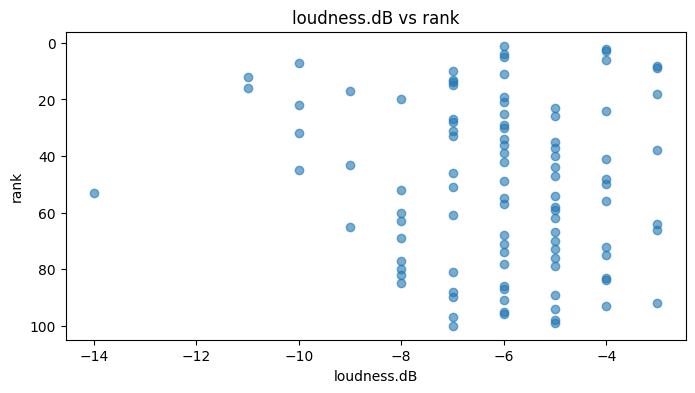

In [16]:
plot(df_top100s, 'loudness.dB', 'rank', reverse=True)

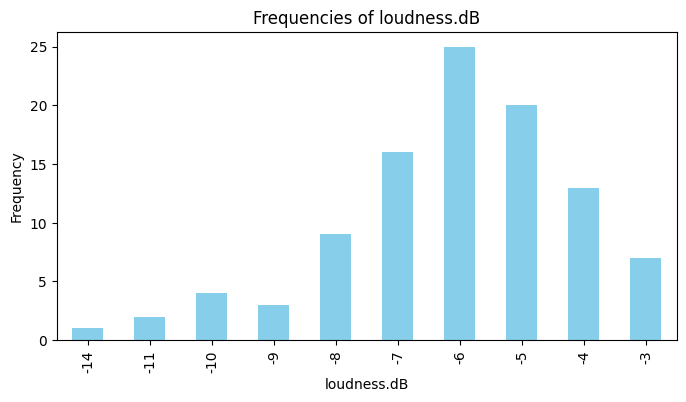

In [17]:
plot_bar(df_top100s, 'loudness.dB')

There's not much to say here about loudness either. Many of the T100's db levels center around -6 db, but this is industry standard practice and is optimized for Spotify streaming and compression algorithms. *()*

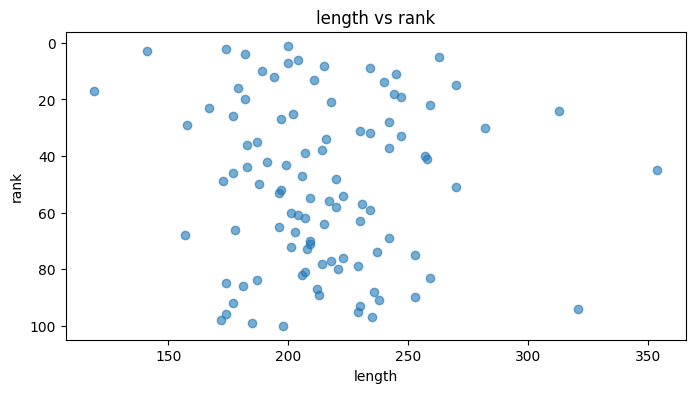

In [18]:
plot(df_top100s, 'length', 'rank', reverse=True)

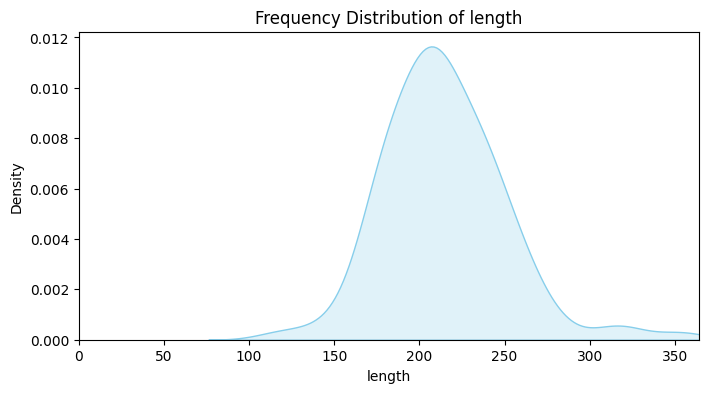

In [19]:
plot_density(df_top100s, 'length', scaled=False)

We have some interesting results here as well. It's become industry standard to have your track be around 3-4 minutes (200s). It seems that high ranking songs on Spotify sit in this sweet spot, with only a handful outside of this range. While not covered in this analysis, it might be worth investigating a potential trend for song lengths over time (are we more accustomed to shorter song lengths nowadays?)

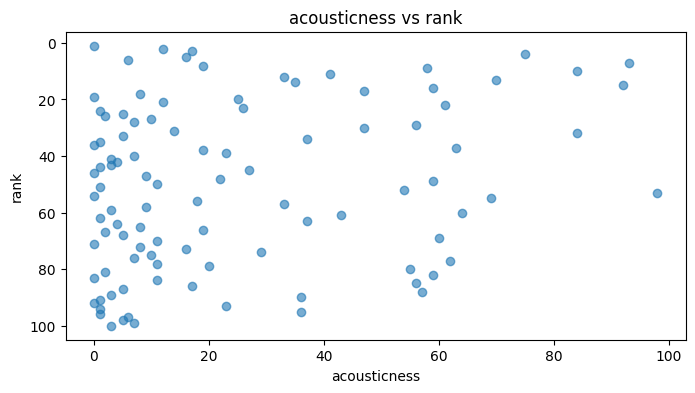

In [20]:
plot(df_top100s, 'acousticness', 'rank', reverse=True)

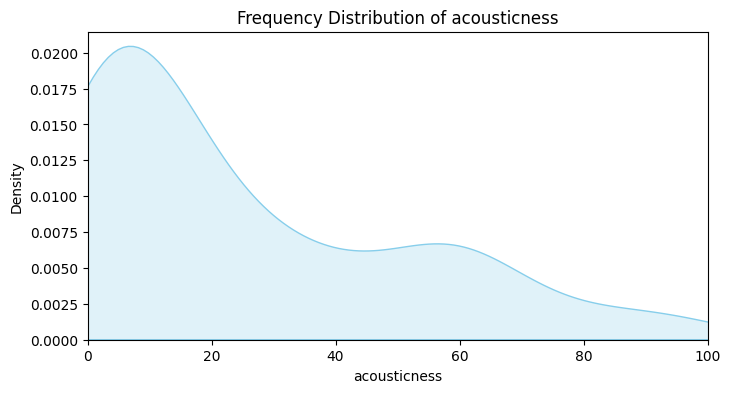

In [21]:
plot_density(df_top100s, 'acousticness')

Okay, now here's something super interesting. Spotify deems the "acousticness" metric to be the likelihood that a song contains more acoustic elements than digital elements. **Many** of the songs in the Top 100 have a very low acousticness score.

In [22]:
freq = split_proportion(df_top100s, 'acousticness', 50)
print(f'{str(freq['above_split'])}% of songs in the top 100 have an acousticness level above 50')
print(f'{str(freq['below_split'])}% of songs in the top 100 have an acousticness level below or equal to 50')
print(f'Mean acousticness of entire set: {str(get_col(df_top100s, "acousticness").mean())}')
print(f'Median acousticness of entire set: {str(get_col(df_top100s, "acousticness").median())}')
print(f'Standard deviation of acousticness of entire set: {str(get_col(df_top100s, "acousticness").std())}')

22% of songs in the top 100 have an acousticness level above 50
78% of songs in the top 100 have an acousticness level below or equal to 50
Mean acousticness of entire set: 24.95
Median acousticness of entire set: 13.0
Standard deviation of acousticness of entire set: 26.278760098665845


In [23]:
print(f'Mean acousticness of top 50: {str(get_rows(df_top100s, 0, 50)["acousticness"].mean())}')
print(f'Median acousticness of top 50: {str(get_rows(df_top100s, 0, 50)["acousticness"].median())}')
print(f'Mean acousticness of bottom 50: {str(get_rows(df_top100s, 50, 100)["acousticness"].mean())}')
print(f'Median acousticness of bottom 50: {str(get_rows(df_top100s, 50, 100)["acousticness"].median())}')

Mean acousticness of top 50: 28.18
Median acousticness of top 50: 18.0
Mean acousticness of bottom 50: 21.72
Median acousticness of bottom 50: 10.5


According to these results, the top 100 songs on Spotify are dominated by digital sounds. This could be for a variety of reasons- a main one being that digital sounds are generally easier to work with as musicians (they are shareable, accessible, and easier to process). You could also make the case that the accessibility of digital sounds makes it easier to produce higher quality work- therefore, people on Spotify tend to appreciate digital music more.

The last metric we observe is speechiness, a metric that Spotify describes as the frequency of spoken content in a song. For example, a fully instrumental song should have a speechiness score of 0, while we expect a rap song or podcast to have a high speechiness score.

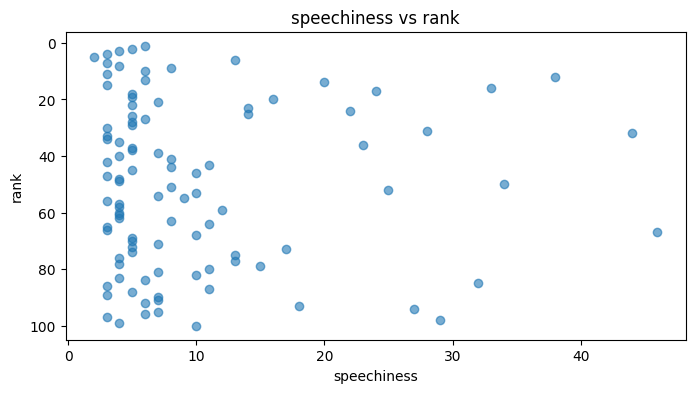

In [24]:
plot(df_top100s, 'speechiness', 'rank', reverse=True)

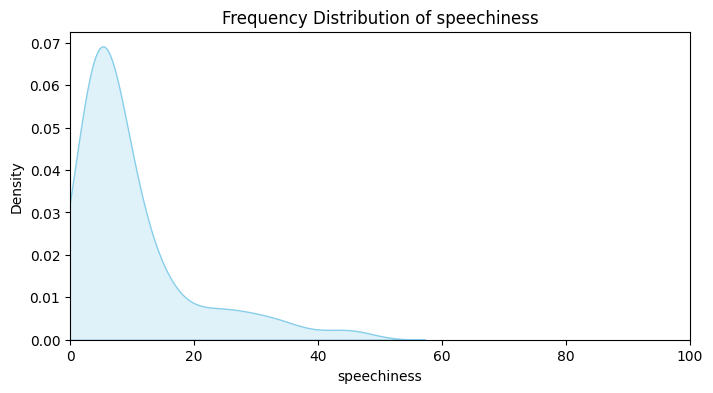

In [25]:
plot_density(df_top100s, 'speechiness')

Although we don't have access to the exact way that Spotify calculates speechiness, it's clear that many tracks fall in the lower half of Spotify's defined spectrum.

In [26]:
freq = split_proportion(df_top100s, 'speechiness', 50)
print(f'{str(freq['above_split'])}% of songs in the top 100 have a speechiness level above 50')
print(f'{str(freq['below_split'])}% of songs in the top 100 have a speechiness level below or equal to 50')
print(f'Mean speechiness of entire set: {str(get_col(df_top100s, "speechiness").mean())}')
print(f'Median speechiness of entire set: {str(get_col(df_top100s, "speechiness").median())}')
print(f'Standard deviation of speechiness of entire set: {str(get_col(df_top100s, "speechiness").std())}')

0% of songs in the top 100 have a speechiness level above 50
100% of songs in the top 100 have a speechiness level below or equal to 50
Mean speechiness of entire set: 9.93
Median speechiness of entire set: 6.0
Standard deviation of speechiness of entire set: 9.424077266408226


In [27]:
print(f'Mean speechiness of top 50: {str(get_rows(df_top100s, 0, 50)["speechiness"].mean())}')
print(f'Median speechiness of top 50: {str(get_rows(df_top100s, 0, 50)["speechiness"].median())}')
print(f'Mean speechiness of bottom 50: {str(get_rows(df_top100s, 50, 100)["speechiness"].mean())}')
print(f'Median speechiness of bottom 50: {str(get_rows(df_top100s, 50, 100)["speechiness"].median())}')

Mean speechiness of top 50: 10.18
Median speechiness of top 50: 5.0
Mean speechiness of bottom 50: 9.68
Median speechiness of bottom 50: 7.0


Although it's not clear exactly how Spotify defines "speechiness," we might be able to conclude that that lyric-heavy music doesn't really exist in the Top 100. Let's check just to make sure:

In [29]:
show(filter(df_top100s, 'top genre', 'rap|hip', contains=True))

rank,title,artist,top genre,year,beats.per.minute,energy,danceability,loudness.dB,liveness,valance,length,acousticness,speechiness,popularity
3,Mood (feat. iann dior),24kGoldn,cali rap,2021,91,72,70,-4,32,73,141,17,4,88
8,Circles,Post Malone,dfw rap,2019,120,76,70,-3,9,55,215,19,4,86
14,Lucid Dreams,Juice WRLD,chicago rap,2018,84,57,51,-7,34,22,240,35,20,84
17,Jocelyn Flores,XXXTENTACION,emo rap,2017,134,39,87,-9,30,44,119,47,24,84
18,goosebumps,Travis Scott,rap,2016,130,73,84,-3,15,43,244,8,5,84
20,ROCKSTAR (feat. Roddy Ricch),DaBaby,north carolina hip hop,2020,90,69,75,-8,10,50,182,25,16,84
21,rockstar (feat. 21 Savage),Post Malone,dfw rap,2018,160,52,59,-6,13,13,218,12,7,83
23,SAD!,XXXTENTACION,emo rap,2018,75,61,74,-5,12,47,167,26,14,83
24,SICKO MODE,Travis Scott,rap,2018,155,73,83,-4,12,45,313,1,22,83
26,Roses - Imanbek Remix,SAINt JHN,melodic rap,2019,122,72,77,-5,35,90,177,2,5,83


Quite interesting results: we don't have the means to see exactly how Spotify calculates speechiness, but there are a lot of hip-hop entries, so I can't say for sure why speechiness is biased towards 0.

### Section 3: Genres in the Top 100